In [116]:
# Importing visualization library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline

# Importing statsmodel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

# Importing sklearn-dataprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

# Importing sklearn-models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
sns.set_theme(style="darkgrid", palette= 'Accent')
pd.options.display.float_format = '{:,.2f}'.format

In [119]:
startups = pd.read_csv('50_Startups.csv')
startups.head()

,R&D Spend,Administration,Marketing Spend,Profit
0,"165,349.20","136,897.80","471,784.10","192,261.83"
1,"162,597.70","151,377.59","443,898.53","191,792.06"
2,"153,441.51","101,145.55","407,934.54","191,050.39"
3,"144,372.41","118,671.85","383,199.62","182,901.99"
4,"142,107.34","91,391.77","366,168.42","166,187.94"


In [120]:
print(startups.shape)
startups.info()

(50, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   Profit           50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [121]:
# Check for missing values
print(startups.isnull().sum())
print("Duplicate data present: ", startups.duplicated().any())

# Basic statistics of the dataset
startups.describe()

R&D Spend          0
Administration     0
Marketing Spend    0
Profit             0
dtype: int64
Duplicate data present:  False


,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,"73,721.62","121,344.64","211,025.10","112,012.64"
std,"45,902.26","28,017.80","122,290.31","40,306.18"
min,0.00,"51,283.14",0.00,"14,681.40"
25%,"39,936.37","103,730.88","129,300.13","90,138.90"
50%,"73,051.08","122,699.79","212,716.24","107,978.19"
75%,"101,602.80","144,842.18","299,469.08","139,765.98"
max,"165,349.20","182,645.56","471,784.10","192,261.83"


# Exploratory Data Analysis (EDA)
Checking for outliers

In [122]:
startups.columns.values

array(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'],
      dtype=object)

<Axes: >

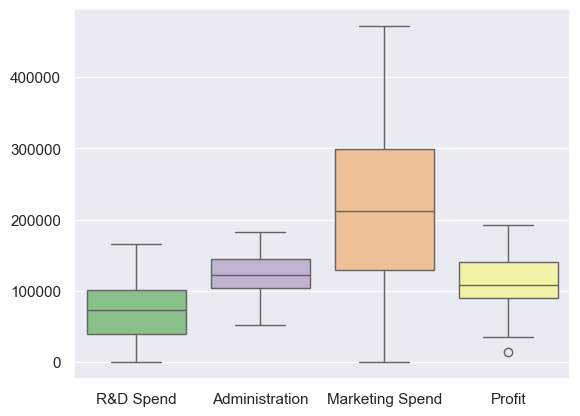

In [123]:
sns.boxplot(data=startups)

In [124]:
# We have an outlier in the profit column.

Q3, Q1 = np.percentile(startups["Profit"], [75, 25])
IQR = Q3 - Q1
startups = startups[~(startups.Profit< (Q1 - 1.5*IQR))]

Visualizing numerical variables

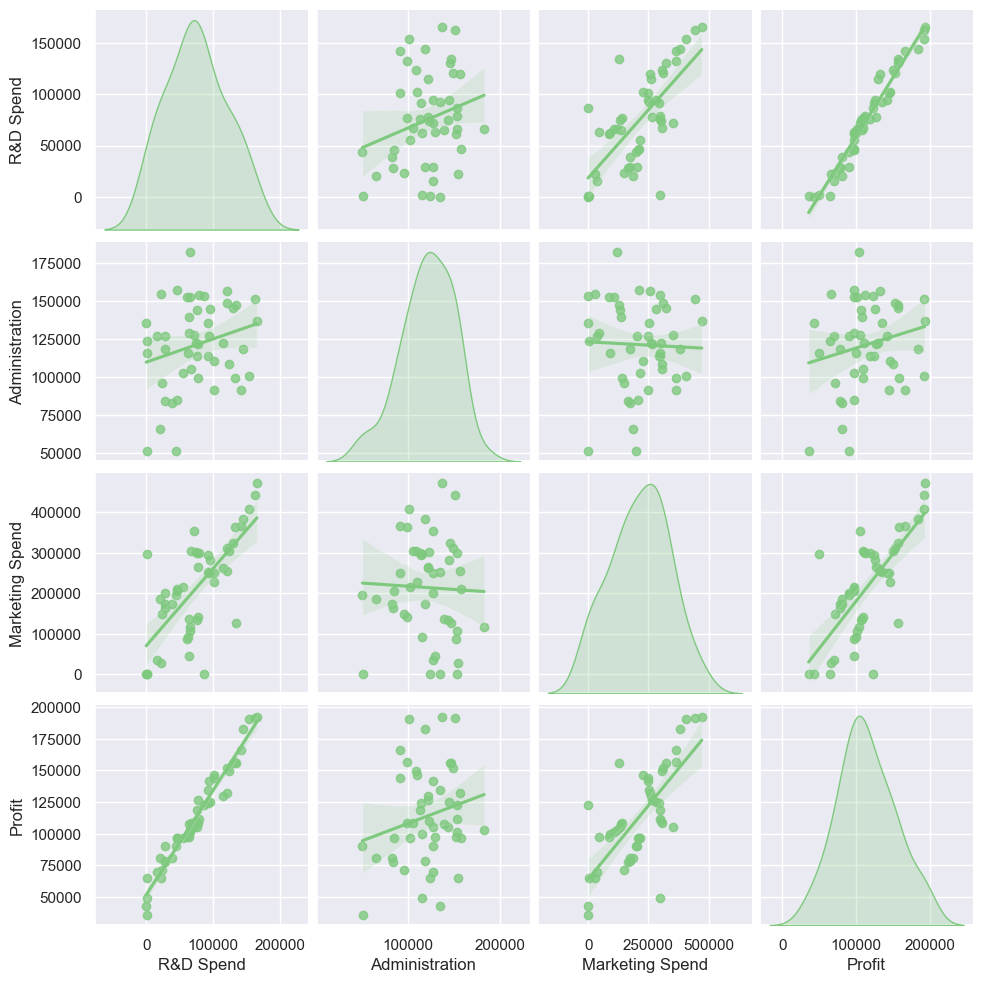

In [125]:
sns.pairplot(startups[['R&D Spend', 'Administration','Marketing Spend', 'Profit']], kind="reg", diag_kind="kde")

Profit distribution

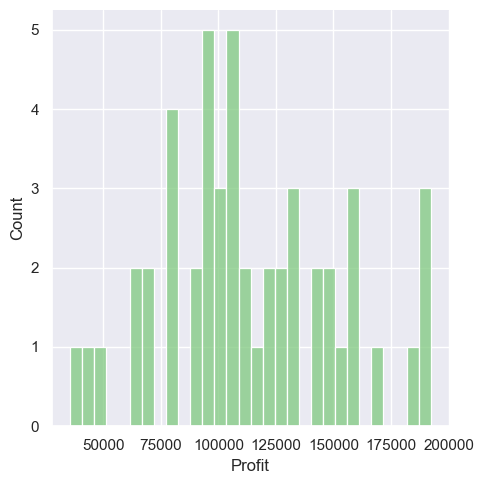

In [126]:
sns.displot(startups["Profit"], bins=30)

<Axes: >

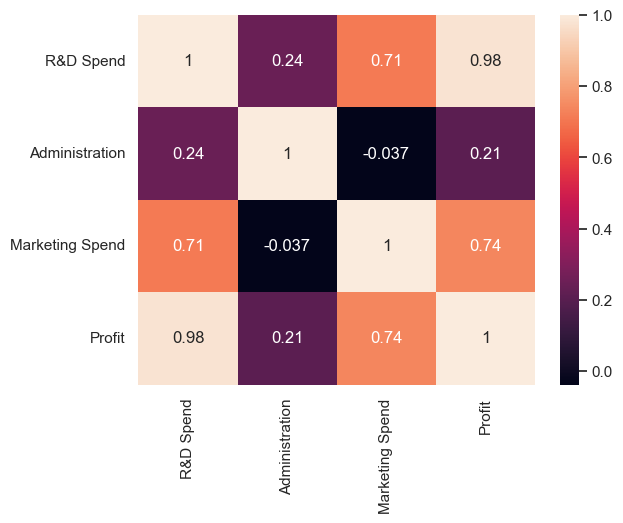

In [127]:
# Correlation between categories
sns.heatmap(startups.corr(), annot= True)

R&D Spend versus Profit correlation

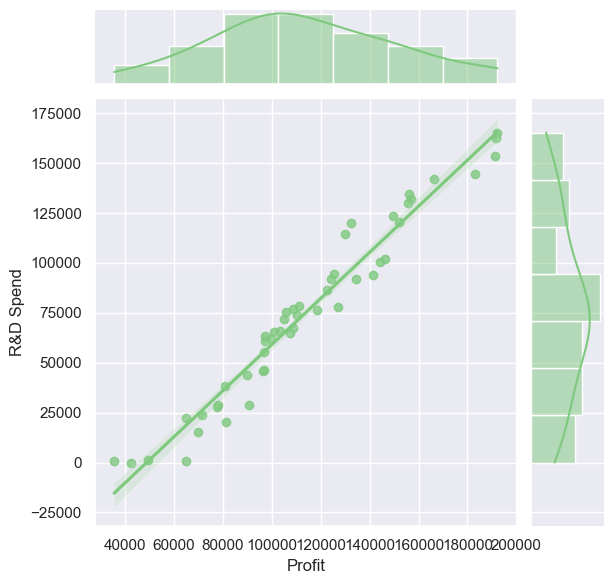

In [128]:
sns.jointplot(x=startups["Profit"], y=startups["R&D Spend"], kind="reg")

# Data preparation

Checking for multi collinearity

In [129]:
startups_prepared = startups.copy()

In [130]:
numerical = startups_prepared.drop(columns=["Profit"])
vif = pd.DataFrame()
vif["Features"] = numerical.columns
vif["VIF"] =  [variance_inflation_factor(numerical.values, i) for i in range(len(numerical.columns))]
vif["VIF"] = round(vif["VIF"],2)
vif = vif.sort_values("VIF", ascending= False)
vif

,Features,VIF
0,R&D Spend,8.60
2,Marketing Spend,7.59
1,Administration,4.22


* VIF scores are higher for R&D and Marketing Spend.

* Since Administration is not so correlated with Profit as other variables, we will consider dropping this variable.

Creating dummy variables

In [131]:
startups_prepared = pd.get_dummies(startups_prepared, drop_first=True)
startups_prepared.rename(columns={"R&D Spend": "R&D", "Marketing Spend":"Marketing"}, inplace=True)

In [132]:
startups_prepared.head()

,R&D,Administration,Marketing,Profit
0,"165,349.20","136,897.80","471,784.10","192,261.83"
1,"162,597.70","151,377.59","443,898.53","191,792.06"
2,"153,441.51","101,145.55","407,934.54","191,050.39"
3,"144,372.41","118,671.85","383,199.62","182,901.99"
4,"142,107.34","91,391.77","366,168.42","166,187.94"


Defining input and target variables

In [133]:
X = startups_prepared.drop(columns="Profit")
y = startups_prepared["Profit"]

Feature selection

In [134]:
data = f_regression(X[["R&D","Administration","Marketing"]],y)
f_df = pd.DataFrame(data, index=[["f_statistic","p_value"]], columns=X[["R&D","Administration","Marketing"]].columns).T
f_df

,f_statistic,p_value
R&D,"1,054.72",0.00
Administration,2.08,0.16
Marketing,56.66,0.00


* R&D and Marketing has nearly 0 p_value what implies statistical significance.
* On the other hand Administration seems to have no significant effect on predicting the profit also previously in correlation as well.

In [135]:
X = X.drop(columns="Administration")

Splitting the data into training and testing sets

In [136]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=6)

Scaling the features

In [137]:
# Scaling inputs
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

# Scaling target variables
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape(-1,1))
y_test = sc_y.transform(y_test.values.reshape(-1,1))

In [138]:
y_train = y_train.reshape(44)
y_test = y_test.reshape(5)

# Model selection and evaluation

Multiple Linear Regression

In [139]:
Rsqr_test = []
order = range(1,4)
for n in order:
    pr = PolynomialFeatures(degree=n)
    X_train_poly = pr.fit_transform(X_train)
    X_test_poly = pr.transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train_poly, y_train)
    Rsqr_test.append(lr.score(X_test_poly,y_test))
Rsqr_test

[0.9607037219297739, 0.9394962923773483, 0.9492791566749258]

In [140]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2_score = lr.score(X_test, y_test)
print(f"Training accuracy score: {lr.score(X_train, y_train)* 100:.1f}%")
print(f"Validation accuracy score: {lr.score(X_train, y_train)* 100:.1f}%")

Training accuracy score: 95.9%
Validation accuracy score: 95.9%


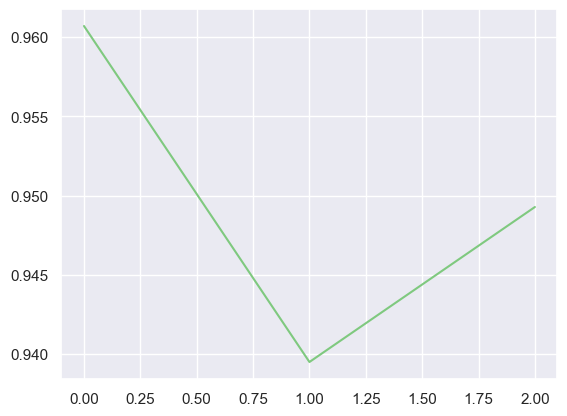

In [141]:
plt.plot(Rsqr_test)

Support Vector Regression

In [142]:
svr = SVR()
svr.fit(X_train, y_train)
print(f"Training accuracy score: {svr.score(X_train, y_train)* 100:.1f}%")
print(f"Validation accuracy score: {svr.score(X_train, y_train)* 100:.1f}%")

Training accuracy score: 94.9%
Validation accuracy score: 94.9%


Decision Tree Regression

In [149]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
print(f"Training accuracy score: {dt.score(X_train, y_train)* 100:.1f}%")
print(f"Validation accuracy score: {dt.score(X_train, y_train)* 100:.1f}%")

Training accuracy score: 100.0%
Validation accuracy score: 100.0%


0.9607037219297739

Rondom Forest Regression

In [144]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(f"Training accuracy score: {rf.score(X_train, y_train)* 100:.1f}%")
print(f"Validation accuracy score: {rf.score(X_train, y_train)* 100:.1f}%")

Training accuracy score: 99.1%
Validation accuracy score: 99.1%


Thus the best performing model is Multiple Regression

In [146]:
r2_score

0.9607037219297739

In [150]:
# Adjusting R-square of the model
n = X_test.shape[0]
p = X_test.shape[1]

adjusted_r2 = 1-(1-r2_score)*(n-1)/(n-p-1)
adjusted_r2

0.9214074438595479

Residual Analysis

In [152]:
y_test_hat = lr.predict(X_test)
y_test_hat

array([-1.742794  , -0.83409916, -0.70464199, -0.14400455,  1.17201929])

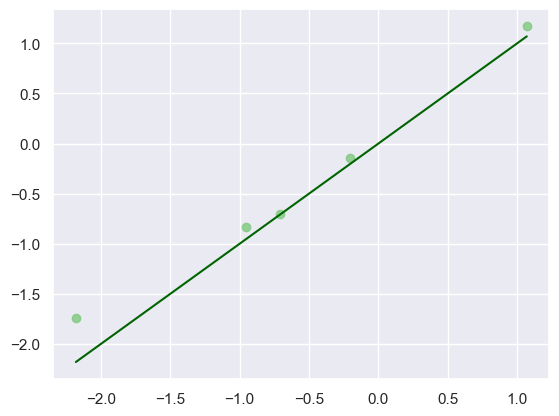

In [153]:
plt.scatter(x=y_test, y = y_test_hat, alpha=0.8)
plt.plot(y_test, y_test, color= 'darkgreen')

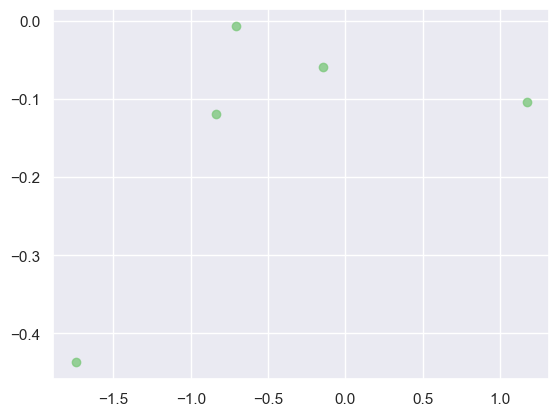

In [154]:
residuals = y_test - y_test_hat
plt.scatter(y=residuals, x=y_test_hat, alpha=0.8)

In [155]:
lr.coef_

array([0.92048117, 0.08213624])

In [157]:
lr.intercept_

2.4490625333787344e-17

In [158]:
# Individual prediction
lr.predict([[130298.1, 323876.68]])

array([146538.96110894])

In [160]:
# Individual prediction
lr.predict([[100671.96, 249744.55]])

array([113179.72248234])

In [161]:
# Individual prediction
lr.predict([[131876.9, 362861.36]])

array([151194.27192413])